Lib imports, ds paths etc.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_paths = {}

for dirname, _, filenames in os.walk('../competitive-data-science-predict-future-sales'):
    for filename in filenames:
        data_paths[filename] = f"{dirname}/{filename}"

In [3]:
data = {}

for file, path in data_paths.items():
    data[file.split('.')[0]] = pd.read_csv(path)

# Functional part for different checks perform

In [4]:
def unique_nan_total(data):
    """
    Checks dataframe for unique values existence, sum of every value, and Nan values.

    :param data: your Dataframe
    :return: Dataframe report table
    """

    report = []

    for table_name, df in data.items():
        for column in df.columns:
            unique_count = df[column].nunique()
            nan_count = df[column].isna().sum()
            total_count = len(df[column])
            dtype = df[column].dtype
            
            report.append({
                'table_name': table_name,
                'column_name': column,
                'unique_count': unique_count,
                'nan_count': nan_count,
                'total_count': total_count,
                'dtype': dtype
            })
    
    report_df = pd.DataFrame(report)
    return report_df

def timeline_check(data):

    """
    Checks timelines for gaps, finds Start date and end date to ensure timeline consistancy.

    :param data: yor Dataframe 
    """
    dates_formatted = []
    dates = list(data['sales_train']['date'])
    for date in dates:
        date = date.replace('.','-')
        dates_formatted.append(date)
    
    dates_formatted = pd.to_datetime(dates_formatted, dayfirst=True)
    first_date = dates_formatted.min()
    last_date = dates_formatted.max()

    unique_dates = list(set(dates_formatted))
    full_date_range = pd.date_range(start=first_date, end=last_date, freq='D')

    missing_dates = full_date_range.difference(unique_dates)
    
    print(f'First date in timeline: {first_date}, last date in timeline: {last_date}\n')
    print('Date skipped:', list(missing_dates)) if len(list(missing_dates)) != 0 else print('No dates skipped.\n')


def min_max_mean(data):

    """
    Perform Dataframe check for minimum, maximum and mean value to help detect outliers.
    
    :param data: your Dataframe
    :return: Dataframe reprt table
    """
    all_stats = []

    for table_name, df in data.items():
        numeric_df = df.select_dtypes(include='number')
        stats = numeric_df.agg(['mean', 'max', 'min']).transpose()
        stats['table_name'] = table_name
        all_stats.append(stats)

    combined_stats = pd.concat(all_stats, axis=0)
    return combined_stats.reset_index()

def skips_check(_list):
    """
    Checks list for skipped values to help understand data consistancy and detect outliers.

    :param _list: List of values
    :return: List of skipped values
    """
    skips = []
    unique_sorted_list = set(list(sorted(_list)))

    for val in range(max(unique_sorted_list)):
        if val not in unique_sorted_list:
            skips.append(val)
            
    return skips

def get_negative_rows_by_column(df):

    """
    Returns negative rows by column from datafrme, in our data should not be any negative values,
    so it'll help detect outliers.

    :param df: your Dataframe
    :return: Dataframe consist of only negative vals
    """
    negative_rows = df[df < 0]
    return negative_rows


def get_negative_rows(df):
    """
    Returns negative rows by from datafrme, in our data should not be any negative values,
    so it'll help detect outliers.

    :param df: your Dataframe
    :return: Dataframe w/o positive rows
    """
    negative_rows = df[(df.select_dtypes(include='number') < 0).any(axis=1)]
    return negative_rows

def count_elements(lst):
    """
    Counts elements in list, finds amount of every element repeatence, helps to find dependencies in data.

    :param lst: List of values (column form DF) 
    :return: dictionary of value: repeat amount 
    """
    element_count = {}
    for element in lst:
        if element in element_count:
            element_count[element] += 1
        else:
            element_count[element] = 1
    return element_count

def get_item_names(items_df, top_returns_dict):
    """
    Used for convert top reurns dict of itrm_id:amount of returns to item_name:amount of returns

    :param items_df: Dataframe of items and their ids
    :param top_returns_dict: Dictionary of itrm_id:amount 
    """
    filtered_items = items_df[items_df['item_id'].isin(top_returns_dict.keys())]
    return filtered_items['item_name'].tolist()

def date_corrector(data):
    """
    Used for converting dates from df to usable format.

    :param data: your Dataframe
    :return: Datafrme w fixed dates
    """
    dates = data['sales_train']['date']
    dates = pd.to_datetime(list(dates), dayfirst=True)
    
    return dates

def shops_sales(data):
    """
    Creates report to show amount of summary saler for every shop over all time.

    :param data: your Dataframe
    :return: Dictionary of shop_id:amount of sales
    """
    report = {}
    shops = data['sales_train']['shop_id']
    for element in shops:
        if element in report:
            report[element] += 1
        else:
            report[element] = 0
    return report

def sales_by_date():
    """
    Shows summary sales for every date in dataset

    :return: Dictionary of date: amount of sales
    """
    
    report = {}
    dates = date_corrector(data)
    for date in dates:
        if date in report:
            report[date] += 1
        else:
            report[date] = 0
    return report

def cleaner(data):
    """
    Perform dataset cleaning based on DQC conclusions for each table in data.

    :param data: A dictionary of DataFrames
    :return: Cleaned data with all DataFrames processed
    """
    cleaned_data = {}
    skips = set(skips_check(data['test']['shop_id']))

    for table_name, df in data.items():
        df_cleaned = df.copy()
        
        for col in df_cleaned.select_dtypes(include=['number']).columns:
            if col != 'item_cnt_day':
                df_cleaned = df_cleaned[df_cleaned[col] >= 0]
        if 'item_price' in df_cleaned.columns:
            df_cleaned = df_cleaned[df_cleaned['item_price'] <= 60000]
        
        if 'item_cnt_day' in df_cleaned.columns:
            df_cleaned = df_cleaned[df_cleaned['item_cnt_day'] <= 200]
        
        if 'shop_id' in df_cleaned.columns:
            df_cleaned = df_cleaned[~df_cleaned['shop_id'].isin(skips)]
            
        cleaned_data[table_name] = df_cleaned
    
    return cleaned_data

def find_unique_items(df):
    """
    Creates
    """
    unique_shop_ids = df['shop_id'].unique()
    all_item_ids = set(df['item_id'].unique())

    result = {}

    for shop_id in unique_shop_ids:
        items_in_shop = set(df[df['shop_id'] == shop_id]['item_id'].unique())
        never_sold_items = all_item_ids - items_in_shop
        result[shop_id] = never_sold_items

    return result

# DQC

### First of all let's check df for unique items, amount of Nan values and total amount of items in every table and column. It can help to understand data consistensy and see if there any outliers.

In [5]:
unique_nan_total(data)

,table_name,column_name,unique_count,nan_count,total_count,dtype
0,items,item_name,22170,0,22170,object
1,items,item_id,22170,0,22170,int64
2,items,item_category_id,84,0,22170,int64
3,item_categories,item_category_name,84,0,84,object
4,item_categories,item_category_id,84,0,84,int64
5,sales_train,date,1034,0,2935849,object
6,sales_train,date_block_num,34,0,2935849,int64
7,sales_train,shop_id,60,0,2935849,int64
8,sales_train,item_id,21807,0,2935849,int64
9,sales_train,item_price,19993,0,2935849,float64


There are several issues with the data. For example, 
- we have 60 different shops in total, but only 42 different shops in the test set
- the item_id counts are: test: 5100, items: 22170, train: 21807
- in the train set, we have unique item_id: 21807, but unique item_price: 19993.

In conclusion, not all data in the dataset is useful for training.

Given the number of dates in the file and the somewhat non-intuitive parameter "date_block_num," we can assume that "date_block_num" refers to months. This means we have data for 34 months between 2013 and 2015, implying that our timeline does not start on the first day of 2013 or end on 31.12.2015. In the worst-case scenario, there are gaps in our data.



### Performing timeline check to see if there any gaps in data.

In [6]:
timeline_check(data)

First date in timeline: 2013-01-01 00:00:00, last date in timeline: 2015-10-31 00:00:00

No dates skipped.



There's no skipped dates, that means there wasn't any day all the franchise stopped it's work.

### To detect outliers checking dataset for min/max/mean values in every table and index. If there is something suspicious we'll perform more specific check.

In [7]:
min_max_mean(data)

,index,mean,max,min,table_name
0,item_id,11084.500000,22169.0,0.0,items
1,item_category_id,46.290753,83.0,0.0,items
2,item_category_id,41.500000,83.0,0.0,item_categories
3,date_block_num,14.569911,33.0,0.0,sales_train
4,shop_id,33.001728,59.0,0.0,sales_train
5,item_id,10197.227057,22169.0,0.0,sales_train
6,item_price,890.853233,307980.0,-1.0,sales_train
7,item_cnt_day,1.242641,2169.0,-22.0,sales_train
8,ID,107099.500000,214199.0,0.0,sample_submission
9,item_cnt_month,0.500000,0.5,0.5,sample_submission


- item_cnt_month has a value of -1, and item_cnt_day has a value of -22. These need to be checked.

- The minimum value of shop_id in the test table is 2, and the maximum is 59. We need to check which shops are missing in the test set.

- The max value of item_cnt_day is 2169, and the mean is 1.2~.

### To check the item_cnt_day firstly need to find the moment where itrm_cnt_day begins to rise. To perform check cycle and plot used.

138 for treshold = 100
61 for treshold = 150
38 for treshold = 200
29 for treshold = 250
23 for treshold = 300
19 for treshold = 350
19 for treshold = 400
15 for treshold = 450
12 for treshold = 500


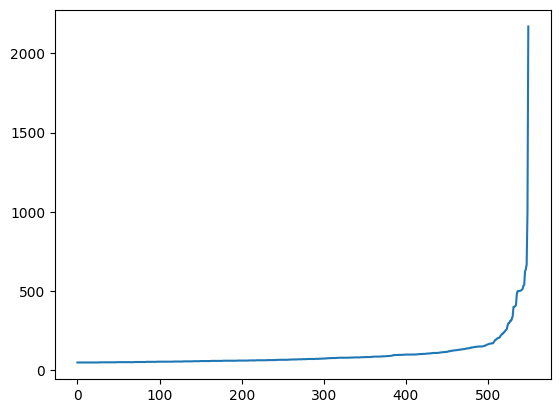

In [8]:
df = data['sales_train']
plt.plot(sorted(df.item_cnt_day)[-550:])

for treshold in [100, 150, 200,250,300,350,400,450,500]:
    check_list = [x for x in sorted(df["item_cnt_day"])[-550:] if x > treshold]
    print(len(check_list), 'for treshold =', treshold)

The amount of values that is more than treshold rises at 150-200, and there's only 61 values that is more than 150. The same thing the plot shows.

Thats can be considered an outliers.

### Checking the item prices, to detect possible outliers. The same way of check, plot and treshold.

240 for treshold = 30000
35 for treshold = 35000
14 for treshold = 40000
4 for treshold = 45000
3 for treshold = 50000
1 for treshold = 60000
[37991.0, 40900.0, 40991.0, 41990.0, 41990.0, 41990.0, 42000.0, 42990.0, 42990.0, 42990.0, 42990.0, 49782.0, 50999.0, 59200.0, 307980.0]


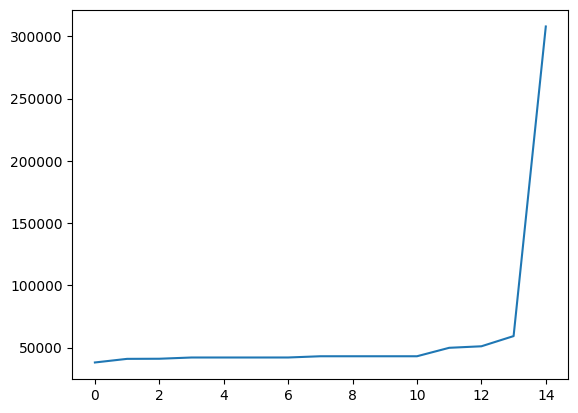

In [9]:
df = data['sales_train']



for treshold in [30000,35000,40000,45000,50000,60000]:
    check_list = [x for x in sorted(df['item_price'])[-250:] if x > treshold]
    print(len(check_list), 'for treshold =', treshold)

print(sorted(df['item_price'])[-15:])

plt.plot(sorted(df['item_price'])[-15:])
plt.show()


The amount of values is rising over the treshold 30000, but the prices seems plausible, so lets check the item names of last 10 the most expensive of them.

In [10]:
max_price_index = df['item_price'].idxmax()
max_price_item_id = df.loc[max_price_index, 'item_id']
for i in range(10):
    print(data['items'].loc[data['items']['item_id'] == max_price_item_id - i, 'item_name'].values[0])


Radmin 3  - 522 лиц.
Radmin 3  - 1 лиц.
Rabbids Invasion [PS4, русская версия]
Rabbids Invasion (только для MS Kinect) [Xbox One, русская версия]
Rabbids Invasion (только для MS Kinect) [Xbox 360, русская версия]
RUSE [PS3]
RS File Recovery. Домашняя версия (Recovery Software) [PC, Цифровая версия]
RS Data Recovery. Домашняя версия (Recovery Software) [PC, Цифровая версия]
ROYKSOPP Junior 2LP
ROYKSOPP  The Inevitable End


Seems like all of th most expensive items are licenses for different applictions, let's consider that prises possible.
The most expensive item is 'Radmin 3  - 522 лиц.', seems it means that item consist of 522 licensions of one application.

Consider 'Radmin 3  - 522 лиц.' as outlier.

### Would be useful to find all the shops that are not in the train set, to avoid using their sales data for training.

Lets check is there really any of such cases via plot.

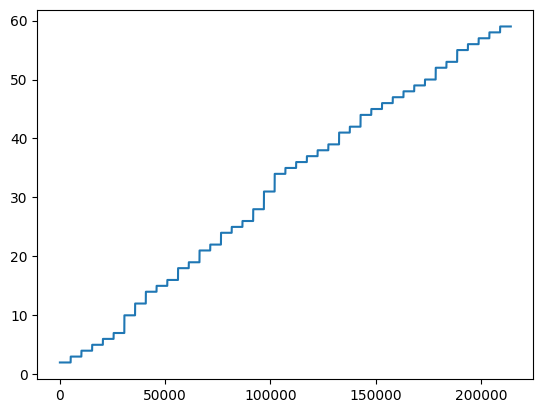

In [11]:
shop_id_unique = (list(data['test']['shop_id']))
plt.plot(sorted(shop_id_unique))
plt.show()

The plot is inconsistent, which suggests there are gaps. Let's verify this using skips check.

In [12]:
skips_check(data['test']['shop_id'])

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]

The shops with ID [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54] are not in the test set, their sales data can not be useful in training.


### Negative values in data check (item_cnt_month = -1, item_cnt_day = -22.)

Firstly check the item price column with value '-1'

In [13]:
get_negative_rows_by_column(data['sales_train']['item_price'])

484683   -1.0
Name: item_price, dtype: float64

Theres only one case of presisting of such type negative value, so it can be considered an outlier an deleted.

Checking all the sales thain for negative values.

In [14]:
get_negative_rows(data['sales_train'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


This occurs systematically, indicating it is not a mistake but possibly just returns. We can try to find the explanation.

Checking the skips in shops, that way we can find the shop IDs that never ha a negative value in item_cnt_day.

In [15]:
skips_check(get_negative_rows(data['sales_train'])['shop_id'])

[0, 1, 10, 11, 13, 51]

Only six shop ID never dealt with a negative values, seems like it's really returns.

Checking for what item_name s are mostly compared with negative values to understan is it really returns. Let's print top-10 of them.

['Bestseller. S.T.A.L.K.E.R. [PC, Jewel]', 'Call of Duty: Ghosts [PS4, русская версия]', 'Grand Theft Auto V [PS3, русские субтитры]', 'Grand Theft Auto V [Xbox 360, русские субтитры]', 'Kinect Rush [только для Kinect] [Xbox 360]', 'Kinect Star Wars [только для Kinect] [Xbox 360]', 'LEGO Batman 2: DC Super Heroes [PС, Jewel, русские субтитры]', 'PS3: Гарнитура беспроводная для PS3 (с поддержкой PS4) (Pulse Wireless Stereo Headset: CECHYA-0086:', 'PS4: Контроллер игровой беспроводной черный (Dualshock 4 Cont Anthracite Black: CUH-ZCT1: SCEE)', 'Одни из нас [PS3, русская версия]']


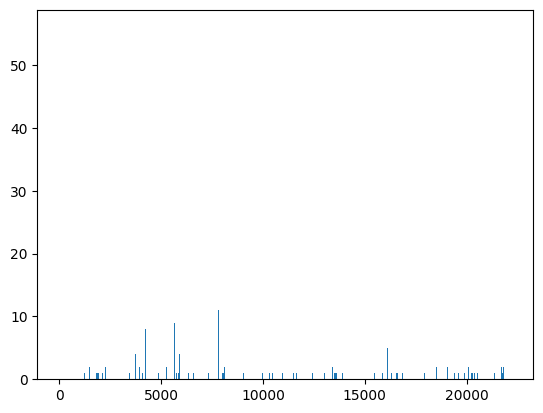

In [16]:
counted_returns = count_elements(get_negative_rows(data['sales_train'])['item_id'])
top_returns = dict(sorted(counted_returns.items(), key=lambda x: x[1], reverse=True)[:10])
print(get_item_names(data['items'], top_returns))

plt.bar(counted_returns.keys(),counted_returns.values())
plt.show()

As we can see, most returns involve video games, which is very plausible. Therefore, we can say that this is certainly not a mistake, and we have to admit it.

### Check for shops that made more sales for better data understanding 

Firstly lets check overall slaes for every shop by creating a hisogramm and printing 5 best selling shops.

{59: 42107, 25: 186103, 24: 53031, 23: 6962, 19: 63910, 22: 45433, 18: 53226, 21: 58132, 28: 142233, 27: 105365, 29: 49224, 26: 53909, 4: 38241, 6: 82662, 2: 25990, 3: 25531, 7: 58075, 0: 9856, 1: 5677, 16: 52733, 15: 59510, 8: 3411, 10: 21396, 14: 36978, 13: 17823, 12: 34693, 53: 52920, 31: 235635, 30: 50859, 32: 7946, 35: 58444, 56: 69572, 54: 143479, 47: 56694, 50: 65172, 42: 109252, 43: 39281, 52: 43501, 51: 44432, 41: 41966, 38: 46012, 44: 39529, 37: 39637, 46: 66320, 45: 35890, 5: 38178, 57: 117427, 58: 71440, 55: 34768, 17: 22949, 9: 3750, 49: 15848, 39: 13439, 40: 4256, 48: 21611, 34: 5751, 33: 5026, 20: 1791, 11: 498, 36: 305}
Shop 31: 235635
Shop 25: 186103
Shop 54: 143479
Shop 28: 142233
Shop 57: 117427


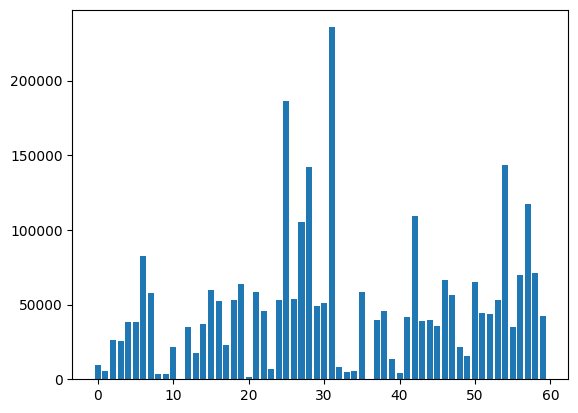

In [ ]:
a = shops_sales(data)
top_5_shops = dict(sorted(a.items(), key=lambda item: item[1], reverse=True)[:5])

for shop, sales in top_5_shops.items():
    print(f"Shop {shop}: {sales}")

plt.bar(a.keys(),a.values())
plt.show()

The check shows that the best selling shops are 31, 25, 54, 28, 57. Woud be useful to check their names.

In [18]:
sales_df = pd.DataFrame(list(a.items()), columns=['shop_id', 'sales'])
top_sales_df = sales_df.nlargest(5, 'sales')

top_sales_with_names = top_sales_df.merge(data['shops'], on='shop_id')

for _, row in top_sales_with_names.iterrows():
    print(f"{row['shop_name']}: {row['sales']}")

Москва ТЦ "Семеновский": 235635
Москва ТРК "Атриум": 186103
Химки ТЦ "Мега": 143479
Москва ТЦ "МЕГА Теплый Стан" II: 142233
Якутск Орджоникидзе, 56: 117427


You can notice similarities in what kind of stores these are by their names: 
- all the stores are located in shopping centers
- almost all are located in Moscow

Now let's check shop sales by dates over the all shops using histogram.

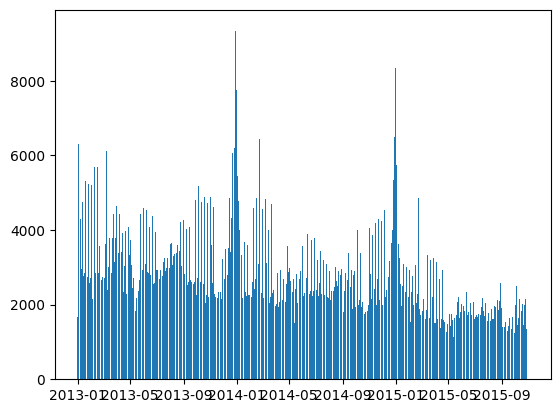

In [19]:
report = sales_by_date()
report = dict(sorted(report.items()))

plt.bar(report.keys(),report.values())
plt.show()

Overall visualizations of sales by date show yearly patterns. Peak sales occur during New Year's holidays. Shop sales show which shops are the most productive.

### Timeline check for every shop separately

There are 50+ shops in dataset, it can be assumed that not every shop existed over the three years that our data covers. Would be useful to check every shop timeline to unerstand their lifetime.

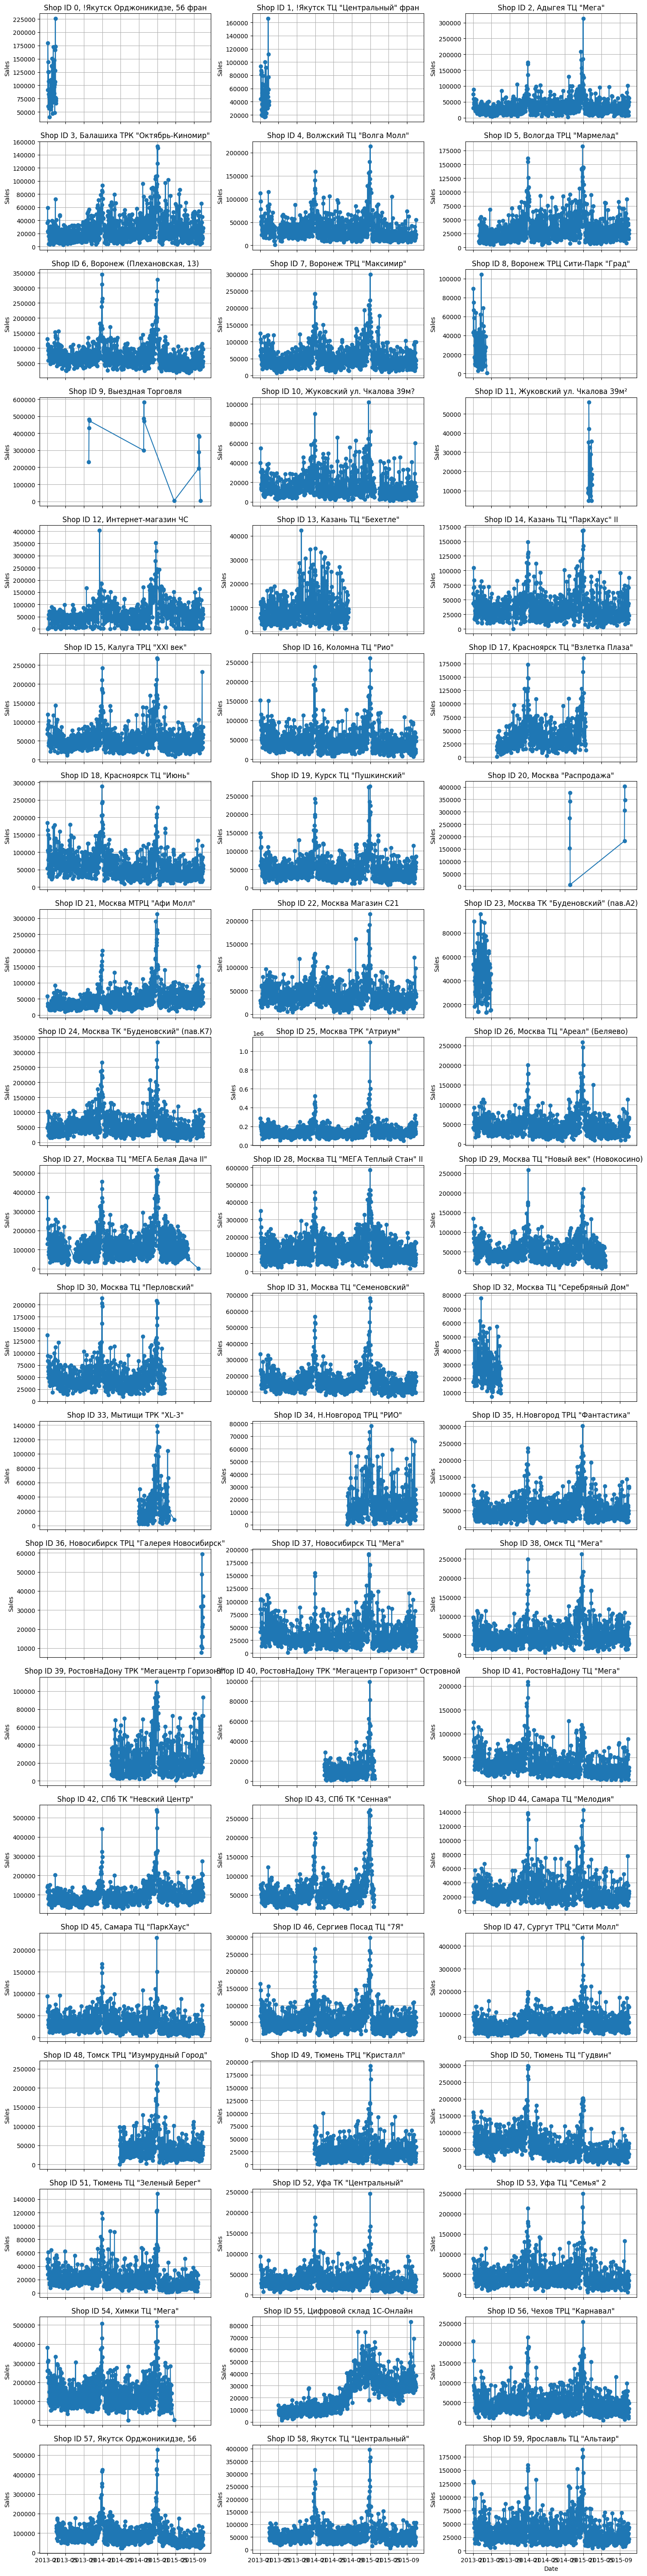

In [20]:
df = pd.DataFrame(data['sales_train'])
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
grouped = df.groupby(['shop_id', 'date'])['item_price'].sum().reset_index()

unique_shops = grouped['shop_id'].nunique()
cols = 3
rows = (unique_shops // cols) + (unique_shops % cols > 0)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 3 * rows), sharex=True)
axes = axes.flatten()

shop_names = dict(zip(data['shops']['shop_id'], data['shops']['shop_name']))

for ax, (shop_id, group) in zip(axes, grouped.groupby('shop_id')):
    ax.plot(group['date'], group['item_price'], marker='o')
    ax.set_title(f'Shop ID {shop_id}, {shop_names.get(shop_id, "Unknown Shop")}')
    ax.set_ylabel('Sales')
    ax.grid(True)

for ax in axes[unique_shops:]:
    ax.set_visible(False)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

Some conclusions based on the graphs:

- sales patterns are quite similar across all shops
- peak sales typically occurring in the last days of each year.
- some shops, like 11, 32, 33, etc., had very short lifespans.
- theres "Sale-out" in Moscow (20) and "Itinerant trade" (9), which operated only a few days a year (these shops are not in the test set, so we can ignore them).

# ETL

After DQC performed we can do the ETL relying on DQC.

- We'll delete all the negative values, except the returns
- Delete the 'Radmin 3  - 522 лиц.' outlier
- Delete all the item_cnt_day that is more than 200, due to it's unrepresentativeness
- Delete non-relevant shops


In [29]:
clean_data = cleaner(data)

In [30]:
for table in clean_data.keys():
    print(clean_data[table].describe(),'\n')

           item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    11084.50000         40.000000
75%    16626.75000         58.000000
max    22169.00000         83.000000 

       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000 

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.413212e+06  2.413212e+06  2.413212e+06  2.413212e+06  2.413212e+06
mean     1.513443e+01  3.228280e+01  1.012342e+04  9.050416e+02  1.232970e+00
std      9.537933e+00  1.641011e+01  6.322088e+03  1.747854e+03  1.727180e+00
min      0.000000e+00  2.000000e+00  1.000000e+00  7.000000e-02 -2.200000e+01
25%      7.000000e+00  2.100000e+01  4.381000e+03  2.4900